# FinBERT: Financial Sentiment Analysis using Language Models

## Table of Contents
- [Introduction and Setup](#introduction)
- [BERT Fine-Tuning on Single Gaudi Card](#bert-fine-tuning-on-single-gaudi-card)
- [Fine-Tuning on Multiple Gaudis](#fine-tuning-on-multiple-gaudis)


## Introduction

This notebook shows how to train [FinBERT](https://arxiv.org/abs/1908.10063) on a Gaudi system. FinBERT is built by further training the BERT language model on a dataset in the finance domain and thus fine-tuning it for financial sentiment classification. Here, we will demonstrain how to use the [Financial PhraseBank](https://arxiv.org/abs/1307.5336v2) dataset for this fine-tuning. You will see how easy and fast it is to train this model on a Gaudi system and how you can further accelerate it using multiple Gaudis. 

## Setup

This notebook runs on a Gaudi system with SynapseAI and Gaudi drivers installed. Please refer to [installation guide](https://docs.habana.ai/en/latest/Installation_Guide/index.html) for more information.

In addition, you need to download and extract Financial PhraseBank dataset from [ResearchGrate](https://www.researchgate.net/publication/251231364_FinancialPhraseBank-v10).

### Install Dependencies

In [1]:
%pip install numpy pandas scikit-learn datasets optimum.habana

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 29.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 184.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 108.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 328.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 107.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 382.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 395.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 236.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 316.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.7/243.7 kB 172.5 MB/s eta 0:00:00
  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 343.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 188.0 MB/s eta 0:00:00
  Created wheel for optimum: filename=optimum-1.8.3-py3-none-any.whl size=318055 sha256=602b45854766b4b19df5a09ed1c02547c171bd3c3a4d51a08bddebe90057bdc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-4d45b4kk/wheels/b3/75/fd/1aa8371cf4bcce9fde5a97cbe65d5cfb1727485d6d7bf71a28
Successfully built optimum

[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# BERT Fine-Tuning on Single Gaudi Card

## Import Modules

In [2]:
import pandas as pd 
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datasets import Dataset
from PIL import Image

from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline 
from optimum.habana import GaudiConfig, GaudiTrainer, GaudiTrainingArguments

## Load Input Data

Each data point in the Financial PhraseBank dataset consists of financial text and label corresponding to sentiment of the text. The sentiment labels are as follows: 0 for _neutral_, 1 for _positive_, and 2 for _negative_ sentiments.

The workflow for loading and preparing input data is shown in the following diagram:

![workflow.svg](workflow.svg)

In [3]:
df = pd.read_csv(
    'FinancialPhraseBank-v1.0/Sentences_50Agree.txt',
    sep='@',
    names=['sentence', 'label'],
    encoding = "ISO-8859-1")
df = df.dropna()
df['label'] = df['label'].map({"neutral": 0, "positive": 1, "negative": 2})
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",0
1,Technopolis plans to develop in stages an area...,0
2,The international electronic industry company ...,2
3,With the new production plant the company woul...,1
4,According to the company 's updated strategy f...,1


In [4]:
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)

dataset_train = Dataset.from_pandas(df_train, preserve_index=False)
dataset_val = Dataset.from_pandas(df_val, preserve_index=False)
dataset_test = Dataset.from_pandas(df_test, preserve_index=False)

## Download Model

BERT model card is available on [HuggingFace](https://huggingface.co/bert-large-uncased).

In [5]:
id2label = {0: "neutral", 1: "positive", 2: "negative"}
model_name = 'bert-large-uncased'

bert_config = AutoConfig.from_pretrained(model_name, id2label=id2label)
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, config=bert_config)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

## Prepare Dataset

Data needs to be transformed to the format accepted by [HuggingFace optimum-habana GaudiTrainer](https://huggingface.co/docs/optimum/habana/package_reference/trainer#optimum.habana.GaudiTrainer) class with fields expected by our model:

In [6]:
dataset_train = dataset_train.map(lambda e: bert_tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: bert_tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: bert_tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train = dataset_train.remove_columns(['sentence'])
dataset_val = dataset_val.remove_columns(['sentence'])
dataset_test = dataset_test.remove_columns(['sentence'])

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

## Train the Model

The [optimum-habana](https://github.com/huggingface/optimum-habana#optimum-habana) library is the interface between transformers and Habana's Gaudi processor (HPU), capable of training models on Gaudi cards with minimal code changes. There are a few new training arguments that are described [here](https://github.com/huggingface/optimum-habana/blob/main/optimum/habana/transformers/training_args.py). 

In [7]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(predictions, labels)}

In [8]:
args = GaudiTrainingArguments(
    output_dir='temp/',
    overwrite_output_dir=True,
    evaluation_strategy='epoch',
    save_strategy='no',
    logging_strategy='epoch',
    logging_dir='logs/',
    report_to='tensorboard',

    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    metric_for_best_model='accuracy',

    use_habana=True,                         # use Habana device
    use_lazy_mode=True,                      # use Gaudi lazy mode
    use_hpu_graphs=True,                     # set value for hpu_graphs
    gaudi_config_name='gaudi_config.json',   # load config file
    
)


You can specify which features to use in a Gaudi configuration, which will take the form of a JSON file as mentioned in <b>gaudi_config.json</b>. Description of each parameter can be found at [Gaudi Configuration](https://huggingface.co/docs/optimum/main/habana/package_reference/gaudi_config).

In [9]:
trainer = GaudiTrainer(
    model=bert_model,                   # the instantiated 🤗 Transformers model to be trained
    args=args,                          # training arguments, defined above
    train_dataset=dataset_train,        # training dataset
    eval_dataset=dataset_val,           # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()  

=============================HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 1
 PT_HPU_LAZY_EAGER_OPTIM_CACHE = 1
 PT_HPU_ENABLE_COMPILE_THREAD = 0
 PT_HPU_ENABLE_EXECUTION_THREAD = 1
 PT_HPU_ENABLE_LAZY_EAGER_EXECUTION_THREAD = 1
 PT_ENABLE_INTER_HOST_CACHING = 0
 PT_ENABLE_INFERENCE_MODE = 1
 PT_ENABLE_HABANA_CACHING = 1
 PT_HPU_MAX_RECIPE_SUBMISSION_LIMIT = 0
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_MAX_COMPOUND_OP_SIZE_SS = 10
 PT_HPU_ENABLE_STAGE_SUBMISSION = 1
 PT_HPU_STAGE_SUBMISSION_MODE = 2
 PT_HPU_PGM_ENABLE_CACHE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
 PT_HCCL_SLICE_SIZE_MB = 16
 PT_HCCL_MEMORY_ALLOWANCE_MB = 0
 PT_HPU_INITIAL_WORKSPACE_SIZE = 0
 PT_HABANA_POOL_SIZE = 24
 PT_HPU_POOL_STRATEGY = 5
 PT_HPU_POOL_LOG_FRAGMENTATION_INFO = 0
 PT_ENABLE_MEMORY_DEFRAGMENTATION = 1
 PT_ENABLE_DEFRAGMENTATION_INFO = 0
 PT_HPU_ENABLE_SYNAPSE_LAYOUT_HANDLING = 1
 PT_HPU_ENABLE_SYNAPSE_OUTPUT_PERMUTE = 1
 PT_HPU_ENABLE_VALID_DATA_RANGE_C

Epoch,Training Loss,Validation Loss,Accuracy,Allocated (gb),Memory Allocated (gb),Memory Available (gb)
1,0.615700,0.474791,0.830664,6.230000,30.040000,30.240000
2,0.323600,0.677619,0.832952,6.230000,30.050000,30.240000
3,0.198700,0.653863,0.848970,6.230000,30.050000,30.240000
4,0.067100,0.938324,0.844394,6.230000,30.050000,30.240000
5,0.026000,0.956983,0.853547,6.230000,30.070000,30.240000


TrainOutput(global_step=2455, training_loss=0.2462169907486366, metrics={'train_runtime': 494.2386, 'train_samples_per_second': 39.697, 'train_steps_per_second': 4.967, 'total_flos': 4575798454548480.0, 'train_loss': 0.2462169907486366, 'epoch': 5.0, 'memory_allocated (GB)': 6.23, 'max_memory_allocated (GB)': 30.07, 'total_memory_available (GB)': 30.24})

## Loss curve

The loss curve is generated by fine-tuning the model for 5 epochs. The below cell shows the loss curve.

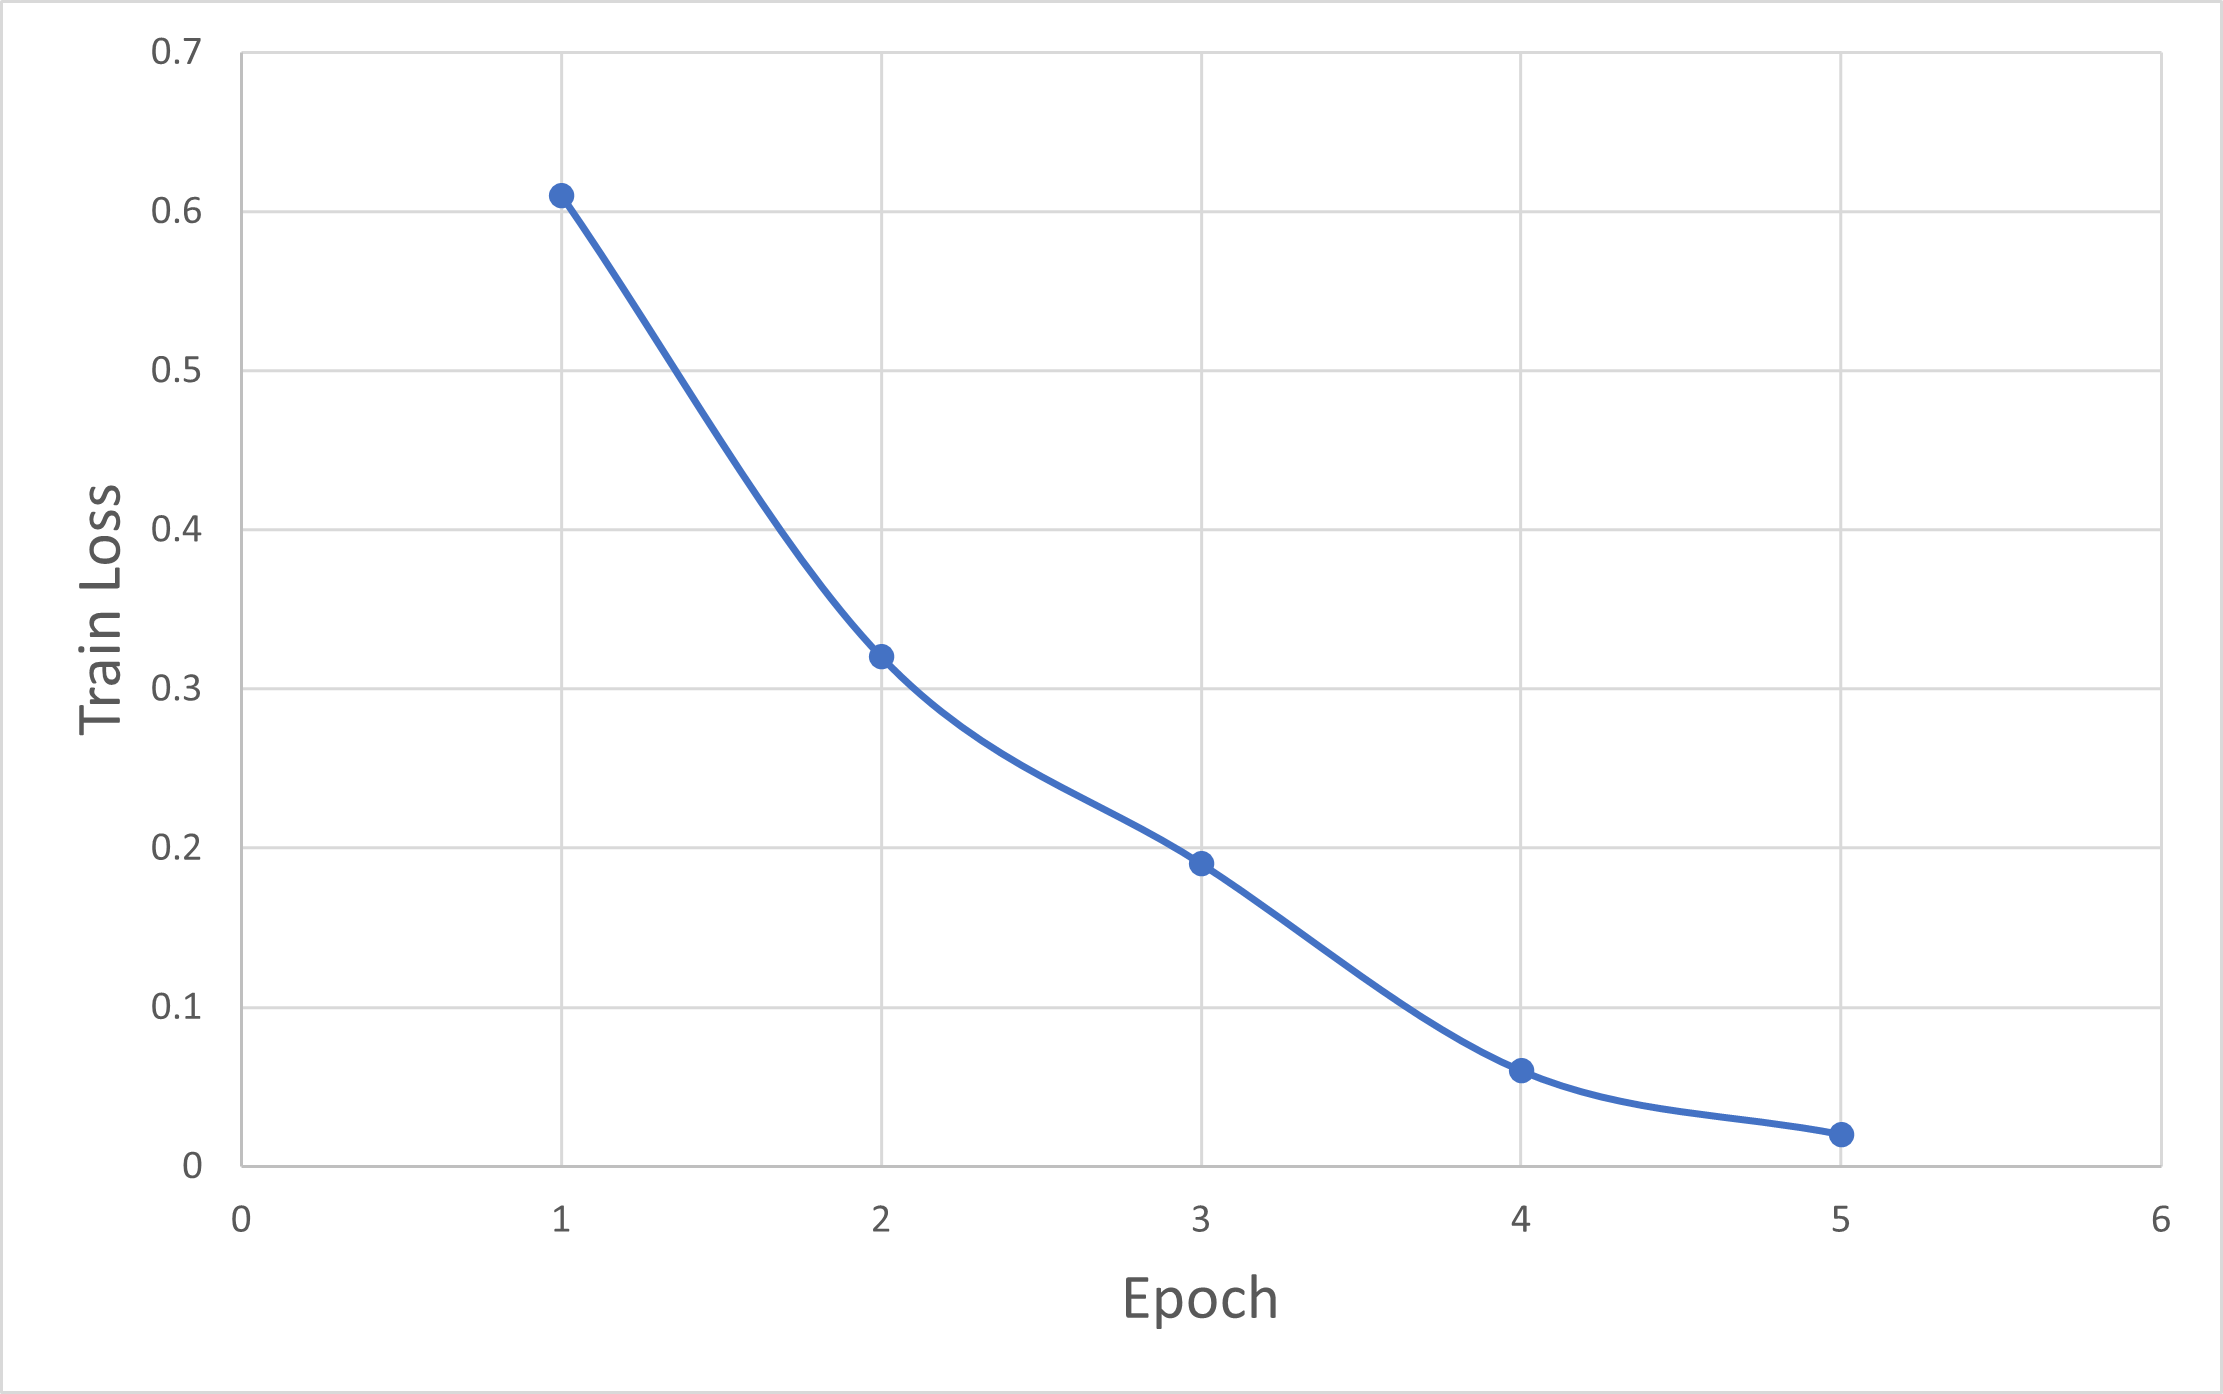

In [10]:
image = Image.open('Loss_curve.png')
image.show()


## Evaluate the Model

Prediction results on train and test data:

In [11]:
trainer.predict(dataset_train, metric_key_prefix="train").metrics

{'train_loss': 0.013415499590337276,
 'train_accuracy': 0.9969418960244648,
 'train_runtime': 43.9404,
 'train_samples_per_second': 89.303,
 'train_steps_per_second': 22.326}

In [12]:
trainer.predict(dataset_test).metrics

{'test_loss': 0.8059211373329163,
 'test_accuracy': 0.8639175257731959,
 'test_runtime': 5.2853,
 'test_samples_per_second': 91.763,
 'test_steps_per_second': 23.083}

## Inference Examples

Here, we run our trained FinBERT model to recognize the sentiments of a few sample statements taken from the New York Times:

In [13]:
pipe = TextClassificationPipeline(model=bert_model, tokenizer=bert_tokenizer)
pipe.device=torch.device('hpu')

print(pipe("Alabama Takes From the Poor and Gives to the Rich"))
print(pipe("Economists are predicting the highest rate of employment in 15 years"))
print(pipe("It’s Been a Poor Year So Far for Municipal Bonds"))
print(pipe("Lavish Money Laundering Schemes Exposed in Canada"))
print(pipe("Stocks edge lower as bank earnings add to concerns about the economy"))

[{'label': 'neutral', 'score': 0.9996854066848755}]
[{'label': 'positive', 'score': 0.9998750686645508}]
[{'label': 'negative', 'score': 0.9984880685806274}]
[{'label': 'neutral', 'score': 0.9937064051628113}]
[{'label': 'negative', 'score': 0.9990912675857544}]


# Fine-Tuning on Multiple Gaudis

The simplest and efficient way of training transformers models on multiple Gaudi cards is by using `mpirun` command. All code cells from this notebook were copied to [finbert.py](finbert.py) python file. In order to run training on multiple cards, please use commands:
```
export MASTER_ADDR="localhost"
export MASTER_PORT="12345"
mpirun -n 8 --bind-to core --map-by socket:PE=7 --rank-by core --report-bindings --allow-run-as-root python finbert.py

``` 